# **Interacting with Open_Clip**

This is a self-contained notebook that shows how to download and run open_clip models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

## Preparation for colab

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
! pip install open_clip_torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x8

In [ ]:
import numpy as np
import torch

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/718M [00:00<?, ?B/s]

In [ ]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x792f90024040>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `tokenizer.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
from open_clip import tokenizer

In [ ]:
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
'''
# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}'''

'\n# images in skimage to use and their textual descriptions\ndescriptions = {\n    "page": "a page of text about segmentation",\n    "chelsea": "a facial photo of a tabby cat",\n    "astronaut": "a portrait of an astronaut with the American flag",\n    "rocket": "a rocket standing on a launchpad",\n    "motorcycle_right": "a red motorcycle standing in a garage",\n    "camera": "a person looking at a camera on a tripod",\n    "horse": "a black-and-white silhouette of a horse",\n    "coffee": "a cup of coffee on a saucer"\n}'

In [ ]:
descriptions = {
    "1": "Every four years the city of Imst in Austria celebrates its Fasnacht carnival on the Sunday before the Christian season of Lent",
    "2": "The central festivity is Schemenlaufen, a procession of masked, costumed dancers",
    "3": "The main characters are in pairs, one man wearing rotating bells and another wearing larger bells weighing up to 35 kg",
    "4": "they perform a special dance of jumps and bows, with the bells producing a mix of high and low tones.",
    "5": "A total of fifty-five such couples participate, while other masked characters slowly imitate their dance",
    "6": "Yet other characters maintain order by softly hitting or splashing the audience with water, while a young girl throws scented powder into the audience.",
    "7": "Masked chimney-sweeps climb houses in feats of bravery, witches shout at the audience accompanied by a band playing dissonant melodies.",
    "8": "Everybody may carve wooden masks and knowledge of traditional craftsmanship is usually passed on within the family or taught in special courses."
}

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
PATH = '/content/drive/My Drive/images/clip2/' #@param{type:"string"}

Mounted at /content/drive


In [ ]:
os.listdir(PATH)

['1.jpg', '2.jpg', '3.jpg', '5.jpg', '6.jpg', '8.jpg', '4.jpg', '7.jpg']

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(PATH) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(PATH, filename)).convert("RGB")
    # print(image)

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()
#print(images)

Output hidden; open in https://colab.research.google.com to view.

## Building features

We normalise the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalise the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

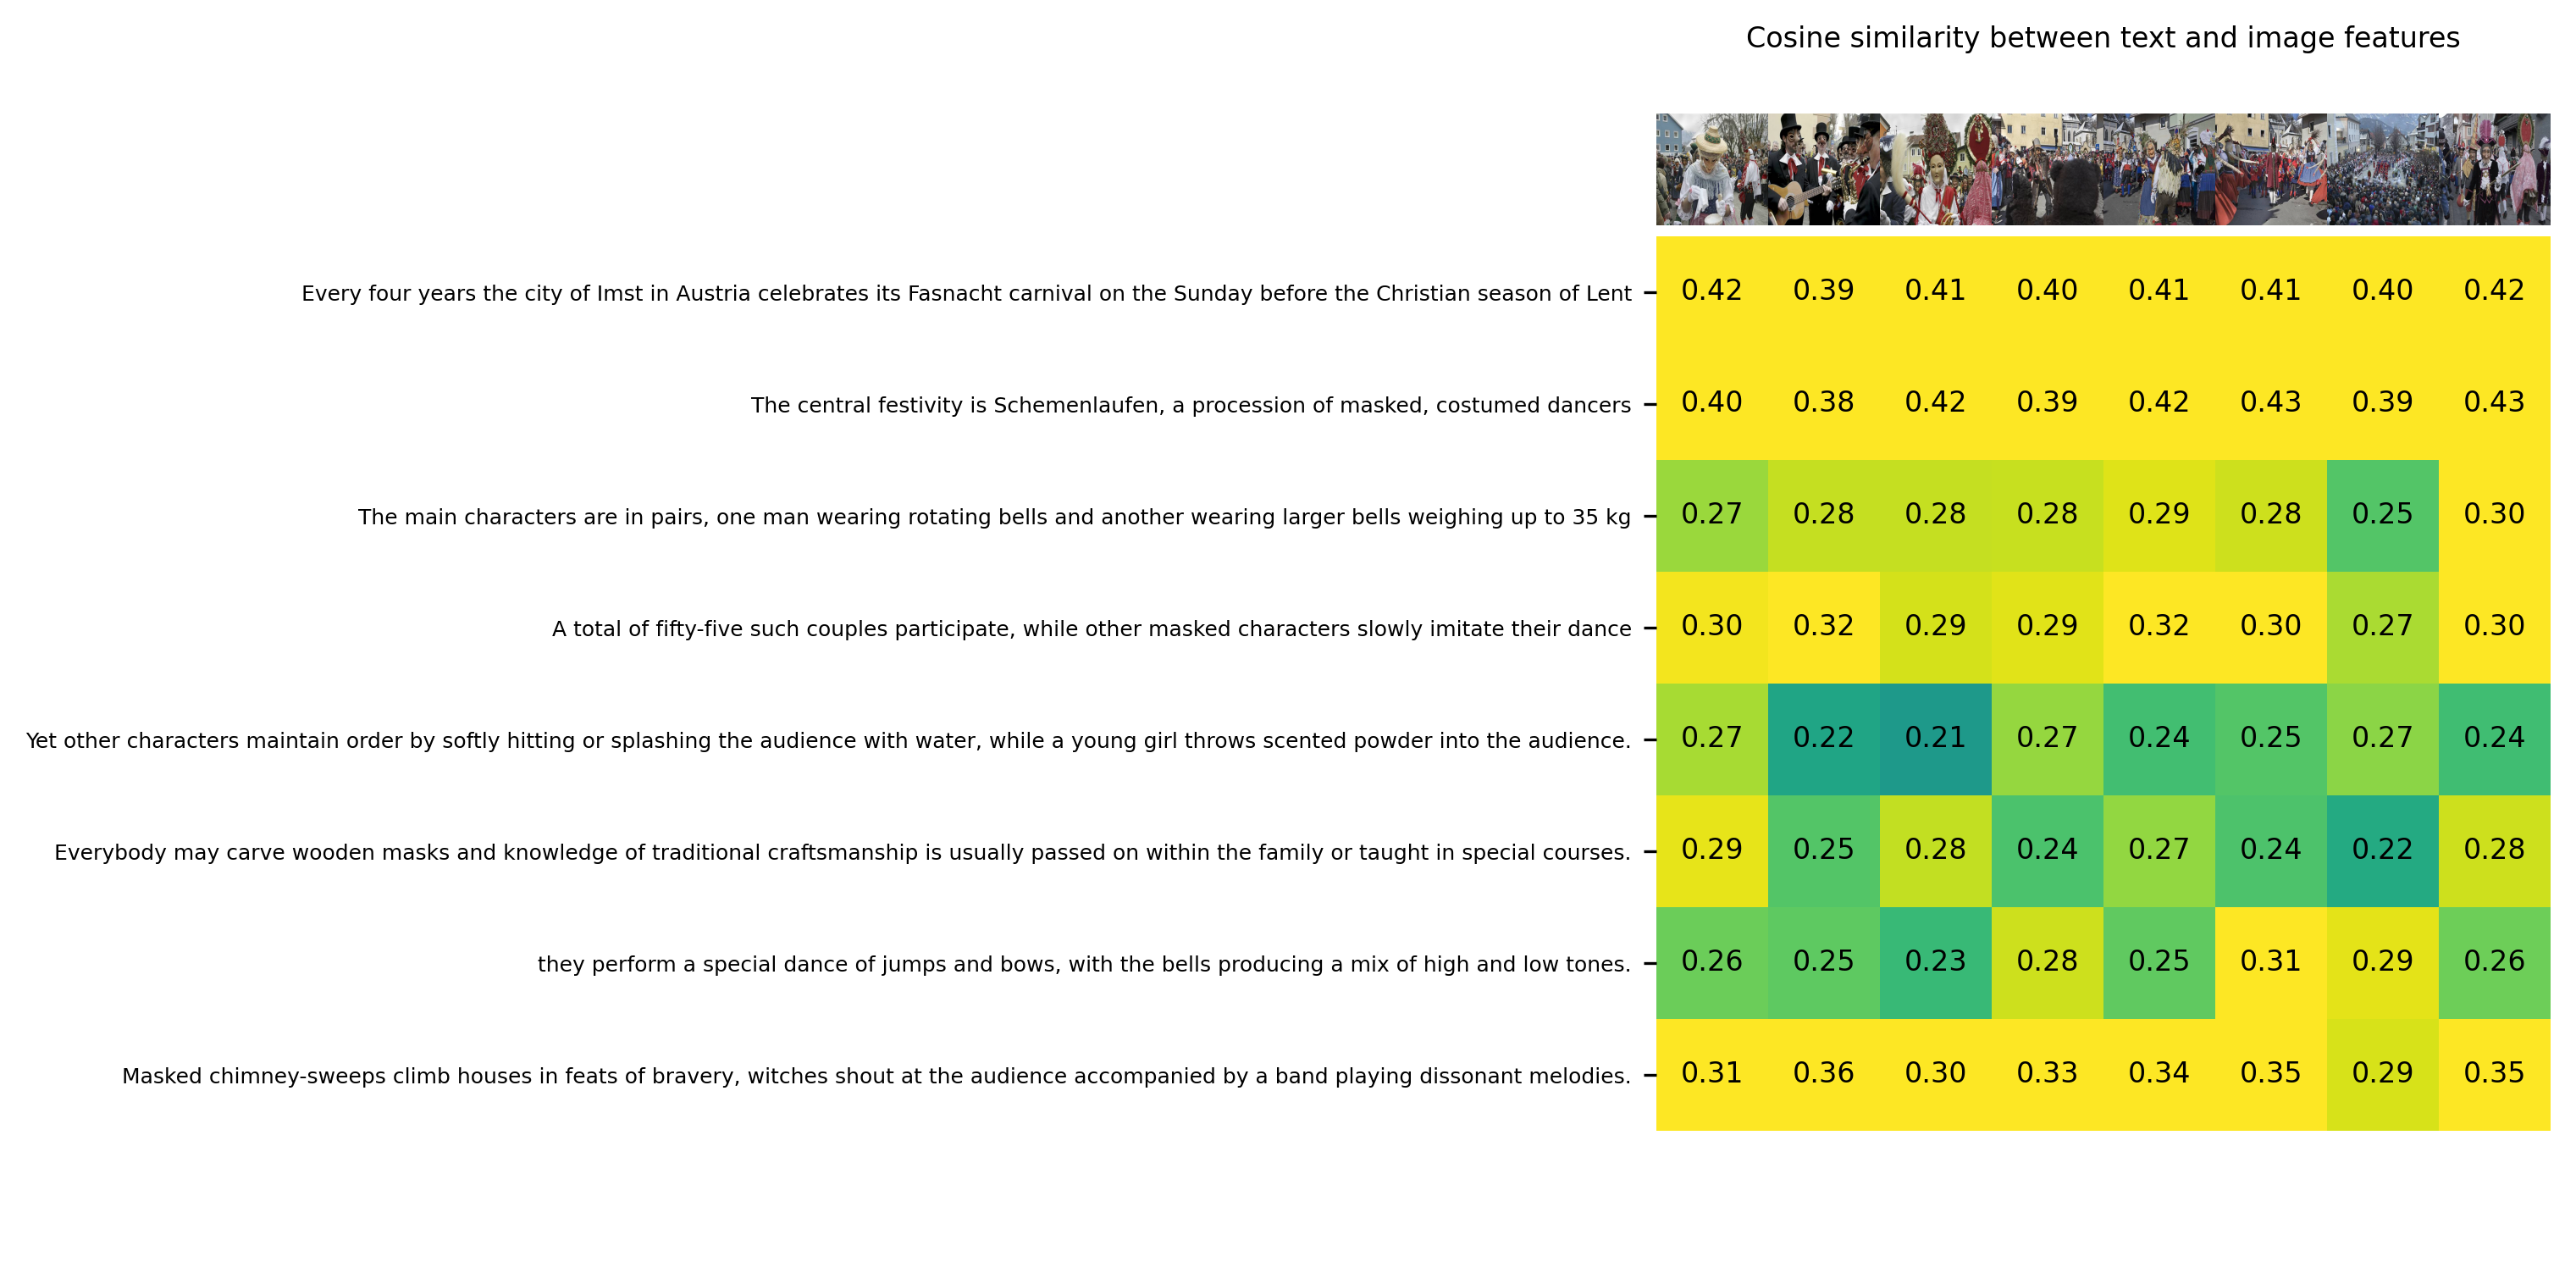

In [ ]:
fontsize_text = 6 #@param{type:'slider', min:0, max:16, step:0.5}
fontsize_cor = 8 #@param{type:'slider', min:0, max:16, step:0.5}
fontsize_ttl = 8 #@param{type:'slider', min:0, max:16, step:0.5}

count = len(descriptions) # Get the number of descriptions

plt.figure(figsize=(9, 6), dpi=150)

# Display the similarity matrix
plt.imshow(similarity, vmin=0.1, vmax=0.3)

# plt.colorbar()
# Set the y-axis labels with the specified font size
plt.yticks(range(count), texts, fontsize=fontsize_text)

# Hide the x-axis labels
plt.xticks([])

# Loop to display each image within the matrix
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Loop to display similarity values on the matrix
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=fontsize_cor)

# Hide the borders of the plot
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Set limits for the x and y axes
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=fontsize_ttl)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 58236233.96it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer.tokenize(text_descriptions)

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(9, 8), dpi=150)

for i, image in enumerate(original_images):
    ax_image = plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    ax_bar = plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i], height=bin_width)
    ax_bar.invert_yaxis()
    ax_bar.set_axisbelow(True)
    ax_bar.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

    # Set font sizes
    ax_bar.tick_params(axis='x', labelsize=xticks_font_size)
    ax_bar.tick_params(axis='y', labelsize=yticks_font_size)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i]])  # Assuming top_labels is defined

    plt.xlabel("probability", fontsize=font_size)
    ax_bar.set_aspect("auto")

plt.subplots_adjust(wspace=0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(9, 8), dpi=150)

for i, image in enumerate(original_images):
    ax_image = plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    ax_bar = plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i], height=bin_width)
    ax_bar.invert_yaxis()
    ax_bar.set_axisbelow(True)
    ax_bar.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

    # Set font sizes
    ax_bar.tick_params(axis='x', labelsize=xticks_font_size)  # Set x-ticks font size
    ax_bar.tick_params(axis='y', labelsize=yticks_font_size)  # Set y-ticks font size
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i]])

    plt.xlabel("probability", fontsize=font_size)
    ax_bar.set_aspect("auto")  # Set aspect ratio for bar charts

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
font_size = 3 #@param{type:'slider', min:0, max:16, step:0.5}
yticks_font_size = 2 #@param{type:'slider', min:0, max:16, step:0.5}
xticks_font_size = 3.5 #@param{type:'slider', min:0, max:16, step:0.5}
bin_width = 0.4 #@param{type:'slider', min:0, max:1, step:0.1}

plt.figure(figsize=(9, 8), dpi=150)

for i, image in enumerate(original_images):
    ax_image = plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    ax_bar = plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i], height=bin_width)
    ax_bar.invert_yaxis()
    ax_bar.set_axisbelow(True)
    ax_bar.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

    # Set font sizes
    ax_bar.tick_params(axis='x', labelsize=xticks_font_size)  # Set x-ticks font size
    ax_bar.tick_params(axis='y', labelsize=yticks_font_size)  # Set y-ticks font size
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i]])

    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()], fontsize=fontsize_xticks)
    plt.xlabel("probability", fontsize=font_size)
    ax_bar.set_aspect("auto")  # Set aspect ratio for bar charts

plt.subplots_adjust(wspace=0.5)
plt.show()